In [58]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
import re

%matplotlib inline

In [42]:
# Uncomment and Run to download packages for nltk
# nltk.download()

# Exercise 1

Read the file and select the 'ExtractedSubject' and 'ExtractedBodyText' columns

In [32]:
df = pd.read_csv('hillary-clinton-emails/Emails.csv')
dff = df[['ExtractedSubject','ExtractedBodyText']].fillna('')
text = dff.to_string(index=False, header=False)

Print a wordcloud of the raw text without preprocessing

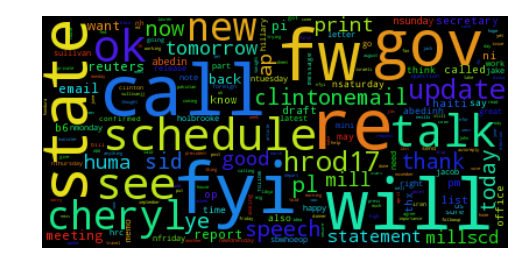

In [138]:
def cloud(text): 
    text = ' '.join(text) if type(text) != str else text
    wordcloud = WordCloud(max_font_size=60).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(text)

## Preprocessing:

Tokenisation

In [114]:
text = text.strip().lower()
tokenizer = RegexpTokenizer(r'\w+')
basic_tokens = tokenizer.tokenize(text)

Remove punctuations and numbers

In [129]:
# punctuation and numbers to be removed
punctuation = re.compile(r'[_\<\>\@\-\.\?!,":;()|0-9]')
single_letter = re.compile('^[a-z]$')
tokens = [punctuation.sub("", word) for word in basic_tokens]  
tokens = [single_letter.sub("", word) for word in tokens]  
tokens = filter(None, tokens)

Remove stop words

In [130]:
my_stopwords = stopwords.words('english') + ['fyi','fwd','fw','thx','bcc','cc','re']
filtered_tokens = [ t for t in tokens if t not in my_stopwords]

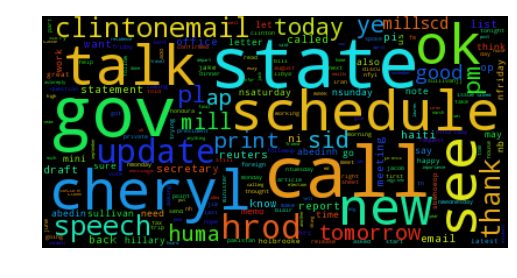

In [139]:
cloud(filtered_tokens)